<a href="https://colab.research.google.com/github/Sabya2/Kaggle----30days-Ml-challenge/blob/main/30_days_ml_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Files and libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Kaggle data/30-days-of-ml/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle data/30-days-of-ml/test.csv')
sample = pd.read_csv('/content/drive/MyDrive/Kaggle data/30-days-of-ml/sample_submission.csv')

# dropping Id column
train.drop(columns = 'id', inplace = True)
test.drop(columns = 'id', inplace = True)

In [ ]:
print('Train Shape', train.shape, '\nTest Shape', test.shape)

Train Shape (300000, 25) 
Test Shape (200000, 24)


# keep run time open

(# comand +option +i)

function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,120000);

# Data exploration

## simple exploration

In [ ]:
train.info()

cat0 - cat9 --> categorical values

cont0 - cont13 --> continuous  values

In [ ]:
train.describe().T

The 5 point stats are not different, thus might not need to scale them, still have to plot to visualise the scale and data distribution

In [ ]:
print('Null in Train', train.isnull().sum().sum())
print('Null in Test', test.isnull().sum().sum())
print('Train Duplicate data', train.duplicated().sum())
print('Test Duplicate data', test.duplicated().sum())

Null in Train 0
Null in Test 0
Train Duplicate data 0
Test Duplicate data 0


Good for me, no null, nop duplicate values in the data set.


## Graphical data exploration

In [ ]:
# lets segregate the cont and cat datasets for data visualisation and cat encoding

print(train.columns, '\n')
train_cont = train.select_dtypes(include=[np.number])
train_cat = train.select_dtypes(exclude=[np.number])

print('cat shape', train_cat.shape)
print('cont shape', train_cont.shape)

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'target'],
      dtype='object') 

cat shape (300000, 10)
cont shape (300000, 15)


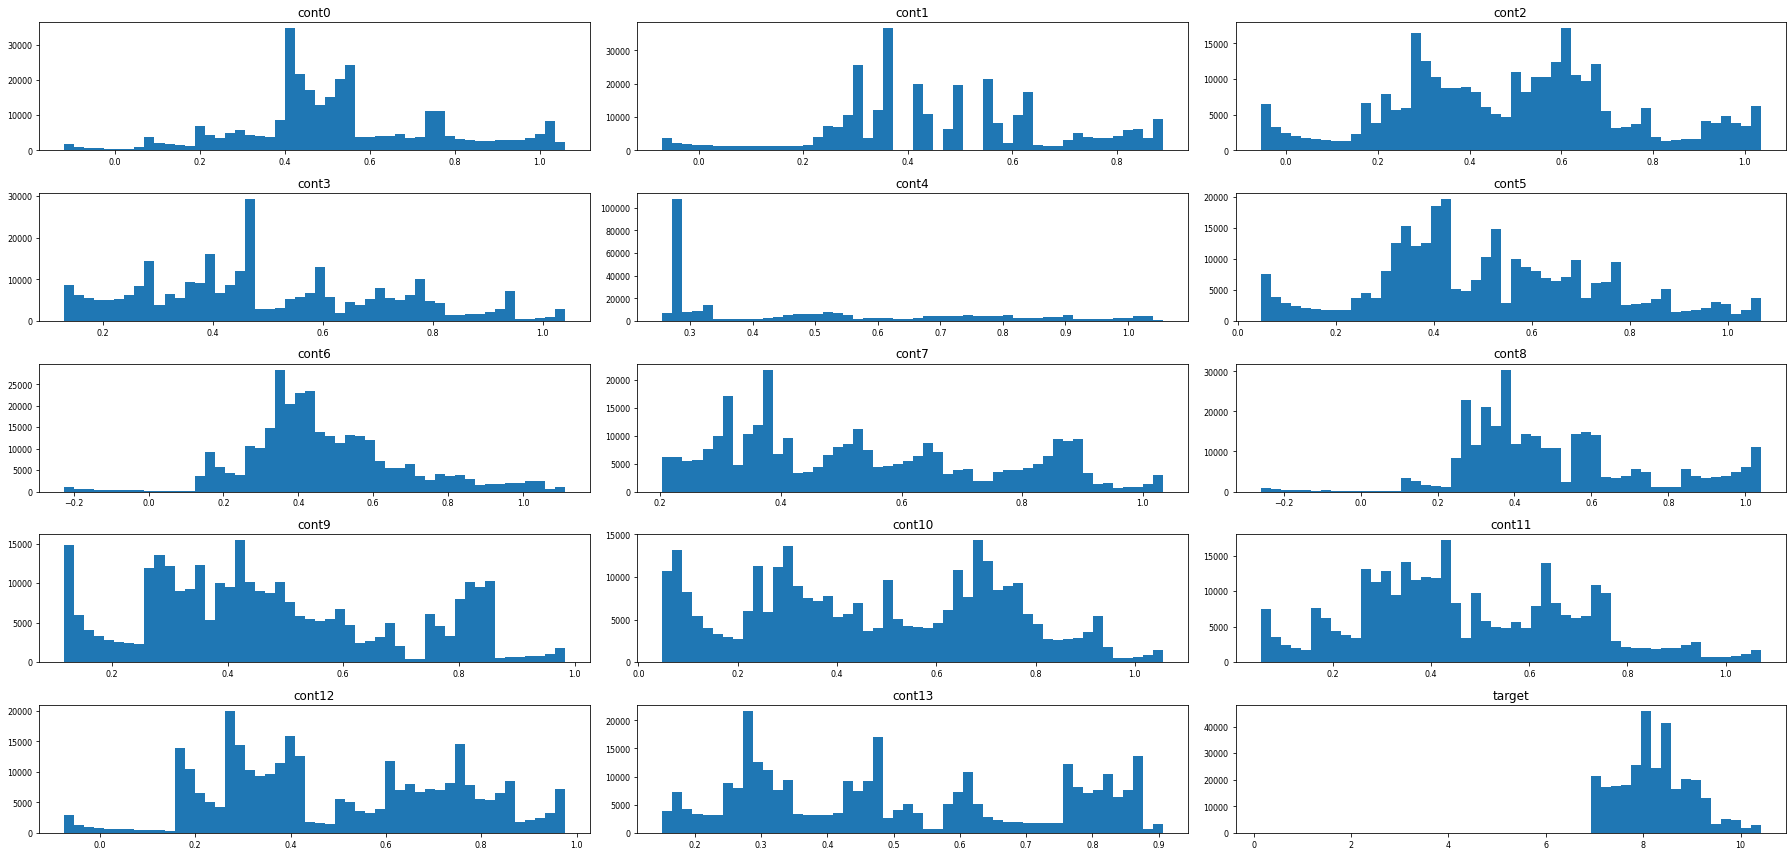

In [ ]:
hist = train_cont.hist(figsize = (25, 12), bins=50, grid = False,
                       xlabelsize=8, ylabelsize=8, layout = (5,3))
plt.tight_layout()

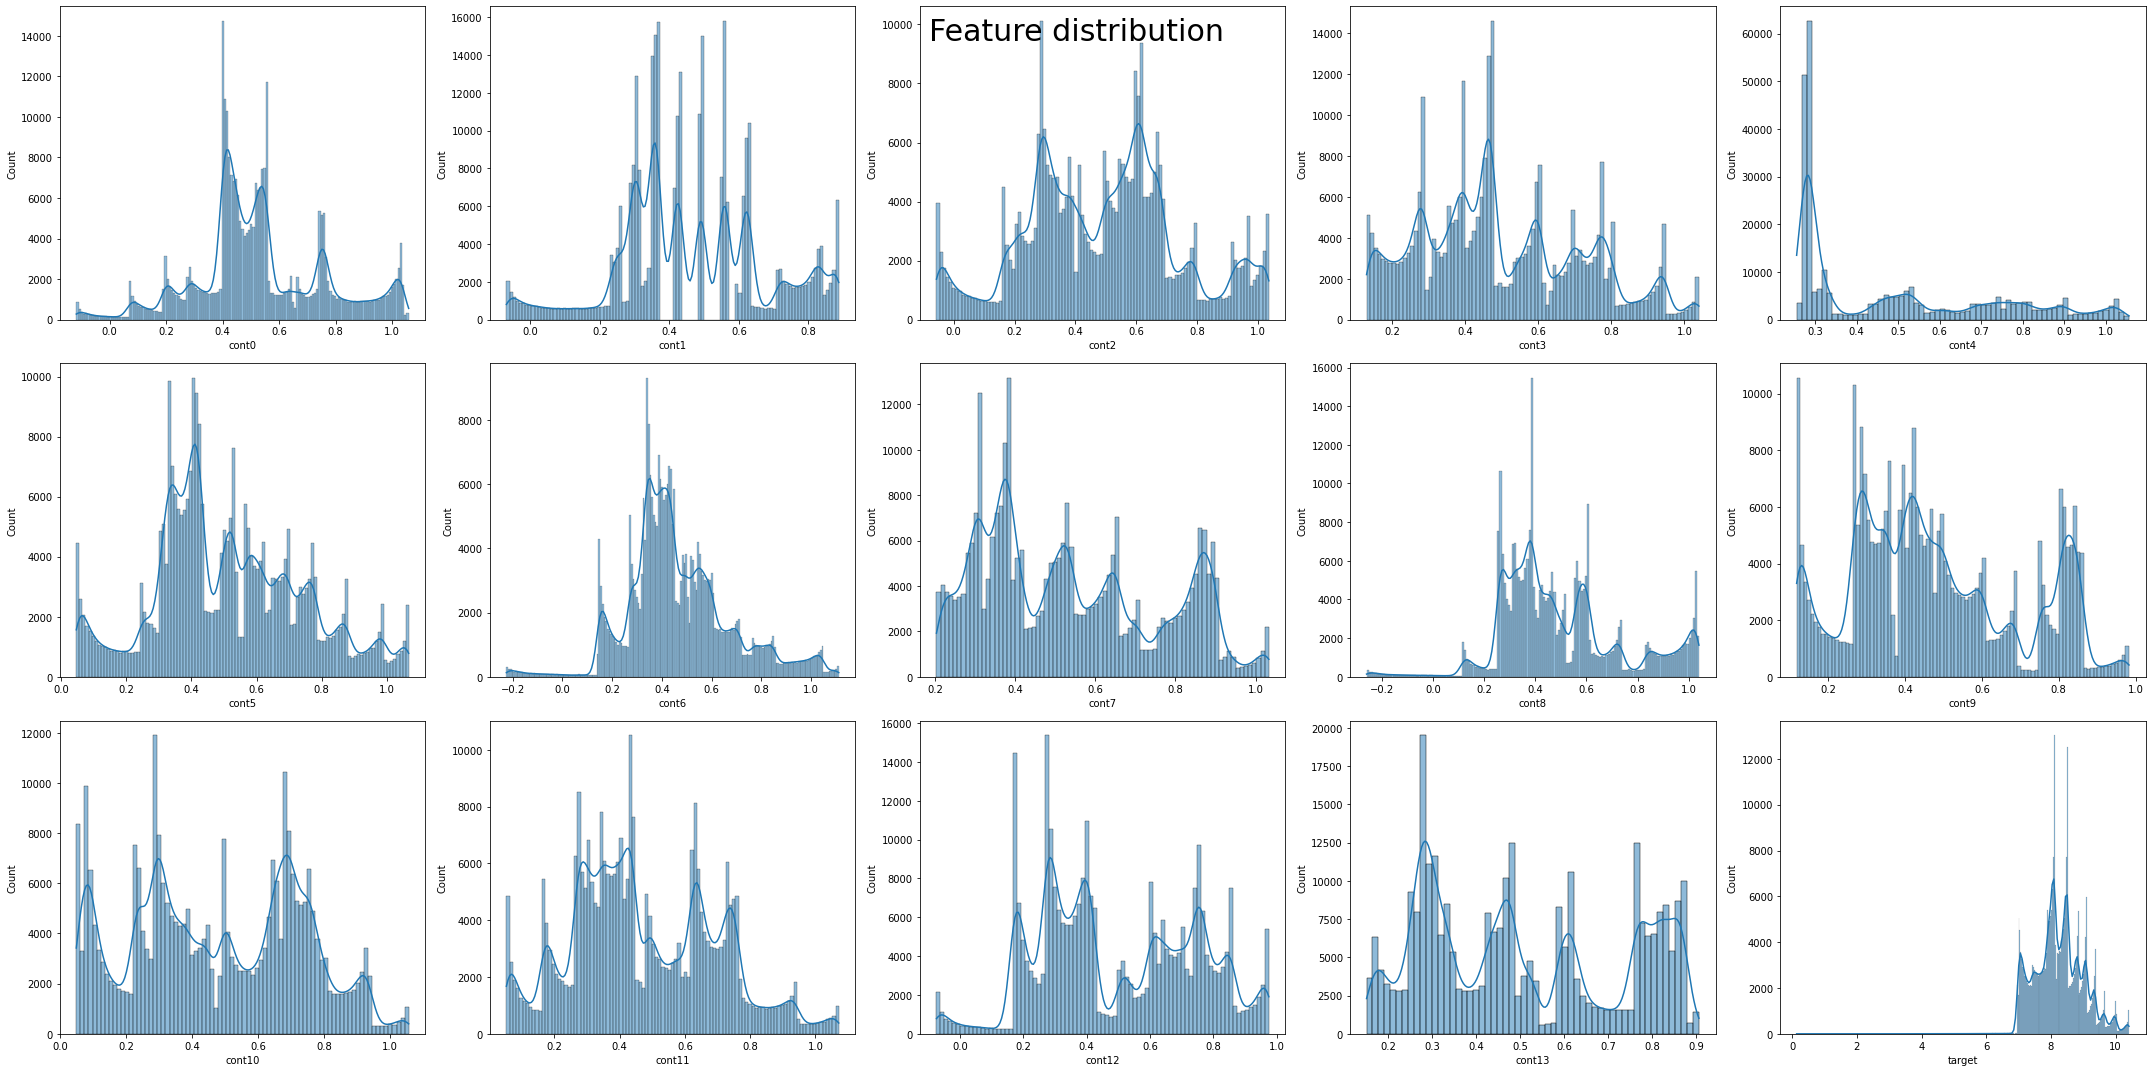

In [ ]:
plt.figure(figsize=(30,15))

for i, column in enumerate(train_cont.columns, 1):
    plt.subplot(3,5,i)
    sns.histplot(train_cont[column], kde = True)
plt.suptitle("Feature distribution", fontsize=30)
plt.tight_layout()

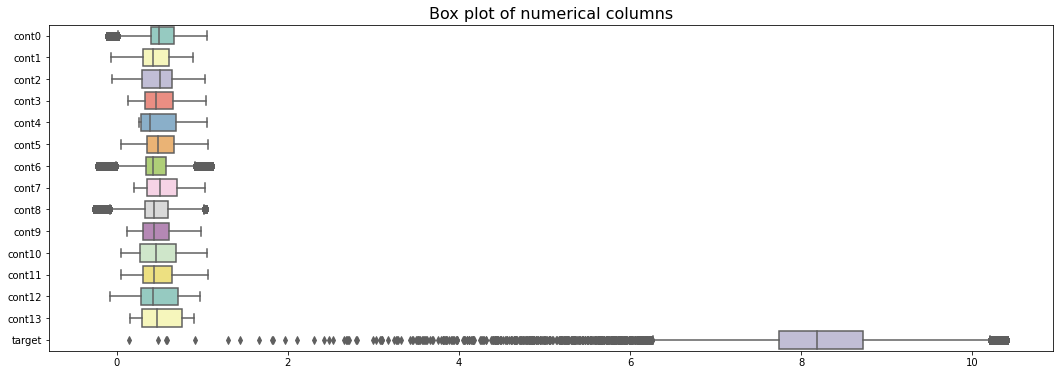

In [ ]:
plt.figure(figsize=(18,6))
ax = sns.boxplot(data=train_cont, orient = 'h', palette="Set3")
plt.title('Box plot of numerical columns', fontsize=16);

The scale of the data is different, thus some scaling function has to be used. Also I will transform the target, to eliminate the skeweness. 

Label encoding of the categorical variables 

# Aims of this project

Ferature engineering on cont variables like - normalisation of the data

Compare One hot enconding and frequency encoding

*Normal transformation of the independent variables*

Effect of log transformation on the accuracy rate

LGBM algorithm



## Separating cont and cat variables

In [ ]:
print(train.columns, '\n')
train_cont = train.select_dtypes(include=[np.number])
train_cat = train.select_dtypes(exclude=[np.number])

print('cat shape', train_cat.shape)
print('cont shape', train_cont.shape)

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'target'],
      dtype='object') 

cat shape (300000, 10)
cont shape (300000, 15)


In [ ]:
print(test.columns, '\n')

test_cont = test.select_dtypes(include = [np.number])
test_cat = test.select_dtypes(exclude = [np.number])

print('test cat shape', test_cat.shape)
print('test cont shape', test_cont.shape)

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13'],
      dtype='object') 

test cat shape (200000, 10)
test cont shape (200000, 14)


# Cont feature engineering

## Independent variables

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scale_train_cont = pd.DataFrame(ss.fit_transform(train_cont.drop('target', axis = 1)), 
                                columns = train_cont.columns[:-1])
scale_train_cont

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,-1.413128,-2.223096,0.707337,-1.644222,0.495896,-0.482690,-1.460606,-1.036942,-0.454261,-0.950948,-0.926791,-0.429435,-0.696182,1.621791
1,0.935532,-0.436982,2.096376,-0.597134,-0.894731,0.098848,0.434769,-0.095470,0.402104,-0.612057,1.685967,2.020007,-0.940532,-0.193720
2,0.933972,-0.703461,-1.986108,0.366188,-0.860487,0.613776,-0.438014,1.675294,0.236534,1.691039,1.071765,0.661691,0.189707,1.146327
3,-0.424046,0.747992,0.345155,-0.985769,-0.862182,0.694266,-1.085979,0.897723,0.755097,0.458571,-0.501981,1.087257,0.184353,-1.020817
4,2.302507,-0.436599,-2.142873,-1.205675,-0.849985,0.773066,-0.222549,0.509137,0.775450,2.210113,2.056196,1.367101,0.530905,-1.154742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.736292,0.105264,-0.760734,-1.372582,-0.765477,1.135977,-0.080531,1.821040,2.111630,1.737805,-0.202973,2.658515,0.821399,-0.008382
299996,-0.351848,1.187882,0.475371,0.479203,1.020766,0.076809,0.195051,-0.819990,-1.002964,-0.189661,-0.677779,-0.922294,0.333590,1.414392
299997,0.073477,-1.869086,0.396520,1.864149,-0.893811,0.780879,-0.451913,-0.789325,-0.480293,0.352985,0.728718,0.704391,0.887936,-1.177580
299998,-0.985578,0.711172,-0.810300,-0.409850,1.309219,-0.727870,-0.205550,-0.710975,-0.123528,-0.568036,-0.725629,0.621351,-0.462237,-0.790503


## Dependent variables

https://stackoverflow.com/questions/28239980/log-transform-dependent-variable-for-regression-tree

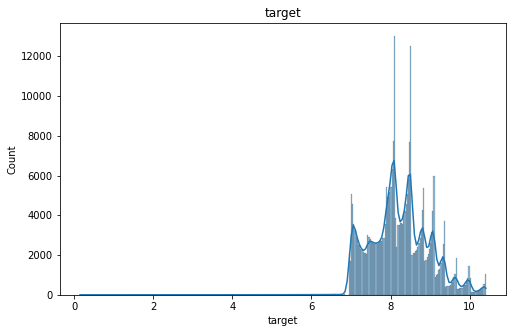

In [ ]:
y = train.iloc[:,-1]

plt.figure(figsize=(8,5))
plt.title('target')
sns.histplot(y, kde = True);

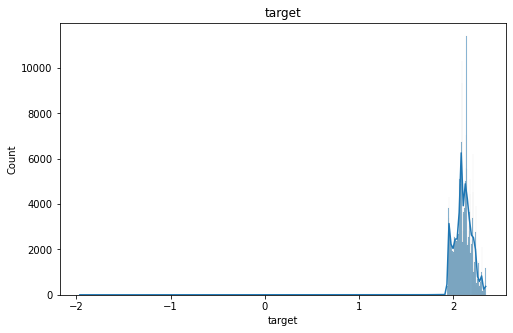

In [ ]:
# log transformation

y_log = np.log(y)

plt.figure(figsize=(8,5))
plt.title('target')
sns.histplot(y_log, kde = True);

# Categorical feature engineering
https://www.geeksforgeeks.org/feature-encoding-techniques-machine-learning/

In [ ]:
train_cat = train.select_dtypes(exclude=[np.number])

## One hot encoding 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_cat = train.select_dtypes(exclude=[np.number])
oh_cat = pd.DataFrame(oh_encoder.fit_transform(train_cat))
oh_cat.head(5)

In [ ]:
# Original x and original y
oh_x = pd.concat([oh_cat, train_cont.drop(columns = 'target')], axis = 1)
oh_x.head(5)

In [ ]:
# scaled x and original y
oh_x_scaled = pd.concat([oh_cat, scale_train_cont], axis = 1)
oh_x_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.413128,-2.223096,0.707337,-1.644222,0.495896,-0.482690,-1.460606,-1.036942,-0.454261,-0.950948,-0.926791,-0.429435,-0.696182,1.621791
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.935532,-0.436982,2.096376,-0.597134,-0.894731,0.098848,0.434769,-0.095470,0.402104,-0.612057,1.685967,2.020007,-0.940532,-0.193720
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.933972,-0.703461,-1.986108,0.366188,-0.860487,0.613776,-0.438014,1.675294,0.236534,1.691039,1.071765,0.661691,0.189707,1.146327
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.424046,0.747992,0.345155,-0.985769,-0.862182,0.694266,-1.085979,0.897723,0.755097,0.458571,-0.501981,1.087257,0.184353,-1.020817
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.302507,-0.436599,-2.142873,-1.205675,-0.849985,0.773066,-0.222549,0.509137,0.775450,2.210113,2.056196,1.367101,0.530905,-1.154742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.736292,0.105264,-0.760734,-1.372582,-0.765477,1.135977,-0.080531,1.821040,2.111630,1.737805,-0.202973,2.658515,0.821399,-0.008382
299996,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.351848,1.187882,0.475371,0.479203,1.020766,0.076809,0.195051,-0.819990,-1.002964,-0.189661,-0.677779,-0.922294,0.333590,1.414392
299997,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073477,-1.869086,0.396520,1.864149,-0.893811,0.780879,-0.451913,-0.789325,-0.480293,0.352985,0.728718,0.704391,0.887936,-1.177580
299998,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.985578,0.711172,-0.810300,-0.409850,1.309219,-0.727870,-0.205550,-0.710975,-0.123528,-0.568036,-0.725629,0.621351,-0.462237,-0.790503


### Model with one hot encoding + original y + original x

In [ ]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2, shuffle=True)

# create model
model = lgb.LGBMRegressor(random_state = 2 )

# evaluate model
scores = cross_val_score(model, oh_x, y, cv = cv, scoring = "neg_mean_absolute_error")
print('One hot encoded + original y + original x + LGBM CV baseline score' , -scores.mean())

One hot encoded + original y + LGBM CV baseline score 0.5754398304841011


In [ ]:
# Data for submission

model.fit(oh_x, y)

test_cont = test.select_dtypes(include = [np.number])

test_cat = test.select_dtypes(exclude=[np.number])
oh_test_cat = pd.DataFrame(oh_encoder.fit_transform(test_cat))

final_test = pd.concat([oh_test_cat, test_cont], axis = 1)


In [ ]:
sample['target'] = model.predict(final_test)
sample.to_csv('submission-> OneHot and no-log.csv', index = False)

### Model with one hot encoding + original y + scaled x

In [ ]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2, shuffle=True)

# create model
model = lgb.LGBMRegressor(random_state = 2 )

# evaluate model
scores = cross_val_score(model, oh_x_scaled, y, cv = cv, scoring = "neg_mean_absolute_error")
print('One hot encoded + scaled x + y + LGBM CV baseline score' , -scores.mean())

One hot encoded + scaled x + y + LGBM CV baseline score 0.5755784926625596


### Model with one hot encoding + log y + original x

In [ ]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2, shuffle=True)

# create model
model = lgb.LGBMRegressor(random_state = 2 )

# evaluate model
scores = cross_val_score(model, oh_x, y_log, cv = cv, scoring = "neg_mean_absolute_error")
print('One hot encoded + original x + log y + LGBM CV baseline score' , -scores.mean())

One hot encoded + original x + log y + LGBM CV baseline score 0.06993194244621938


### Model with one hot encoding + log y + scaled x

In [ ]:
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2, shuffle=True)

# create model
model = lgb.LGBMRegressor(random_state = 2 )

# evaluate model
scores = cross_val_score(model, oh_x_scaled, y_log, cv = cv, scoring = "neg_mean_absolute_error")
print('One hot encoded + scaled x + log y + LGBM CV baseline score' , -scores.mean())

One hot encoded + scaled x + log y + LGBM CV baseline score 0.06995021360100673


In [ ]:
# Data for submission

model.fit(oh_x_scaled, y_log)

test_cont = test.select_dtypes(include = [np.number])
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scale_test_cont = pd.DataFrame(ss.fit_transform(test_cont), columns = test_cont.columns)

test_cat = test.select_dtypes(exclude = [np.number])
oh_test_cat = pd.DataFrame(oh_encoder.fit_transform(test_cat))

final_test = pd.concat([oh_test_cat, scale_test_cont], axis = 1)


In [ ]:
sample["target"] = np.exp(model.predict(final_test))
sample.to_csv('submission-> OneHot and scaled_x and y_log.csv', index = False)

,id,target
0,0,7.954526
1,5,8.280709
2,15,8.266477
3,16,8.452761
4,17,8.183663
...,...,...
199995,499987,8.067352
199996,499990,8.341142
199997,499991,8.318603
199998,499994,8.100187


## Inference 

With one hot encoding, the non scaled x and y worked on basic LGBM algorithm

## Frequency encoding

In [ ]:
train_cat.columns
train_cont.columns

Index(['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'target'],
      dtype='object')

In [ ]:
# Creating the Frequency encoding

freq_cat = pd.DataFrame()
for i in range (10):
  # print(f'freq_cat{i}')
  enc_nom = (train_cat.groupby(f'cat{i}').size()) / len(train_cat)
  freq_cat[f'freq_cat{i}'] = train_cat[f'cat{i}'].apply(lambda x :enc_nom[x])

freq_cat

,freq_cat0,freq_cat1,freq_cat2,freq_cat3,freq_cat4,freq_cat5,freq_cat6,freq_cat7,freq_cat8,freq_cat9
0,0.356233,0.48392,0.153713,0.877853,0.982457,0.497800,0.96837,0.920133,0.370343,0.055680
1,0.356233,0.48392,0.846287,0.105753,0.982457,0.420457,0.96837,0.001873,0.255283,0.047343
2,0.643767,0.51608,0.846287,0.877853,0.982457,0.420457,0.96837,0.040480,0.255283,0.237497
3,0.356233,0.48392,0.846287,0.877853,0.982457,0.420457,0.96837,0.920133,0.370343,0.060190
4,0.643767,0.51608,0.846287,0.877853,0.982457,0.420457,0.96837,0.920133,0.255283,0.055680
...,...,...,...,...,...,...,...,...,...,...
299995,0.356233,0.48392,0.846287,0.105753,0.982457,0.420457,0.96837,0.920133,0.255283,0.197393
299996,0.643767,0.48392,0.846287,0.877853,0.982457,0.497800,0.96837,0.920133,0.266147,0.237497
299997,0.356233,0.48392,0.846287,0.877853,0.982457,0.067493,0.96837,0.920133,0.087093,0.237497
299998,0.643767,0.48392,0.846287,0.877853,0.982457,0.497800,0.96837,0.920133,0.266147,0.197393


### Model on original x and y

In [ ]:
# original x and original y
freq_x = pd.concat([freq_cat, train_cont], axis = 1)
freq_x

In [ ]:
y = freq_x['target']
x = freq_x.drop(columns = 'target')

# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2, shuffle=True)

# create model
model = lgb.LGBMRegressor(random_state = 2 )

# evaluate model
scores = cross_val_score(model, x, y, cv = cv, scoring = "neg_mean_absolute_error")
print('Freq encoded + original y + original x + LGBM CV baseline score' , -scores.mean())

One hot encoded + original y + original x + LGBM CV baseline score 0.5754897527128999


In [ ]:
# Data for submission

model.fit(x,y)

test_cont = test.select_dtypes(include = [np.number])
test_cat = test.select_dtypes(exclude = [np.number])

freq_test_cat = pd.DataFrame()
for i in range (10):
  # print(f'freq_cat{i}')
  enc_nom = (test_cat.groupby(f'cat{i}').size()) / len(test_cat)
  freq_test_cat[f'freq_cat{i}'] = test_cat[f'cat{i}'].apply(lambda x :enc_nom[x])

final_test = pd.concat([freq_test_cat, test_cont], axis = 1)
final_test


,freq_cat0,freq_cat1,freq_cat2,freq_cat3,freq_cat4,freq_cat5,freq_cat6,freq_cat7,freq_cat8,freq_cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0.35585,0.48413,0.153115,0.877400,0.982675,0.500875,0.967595,0.91898,0.267630,0.197390,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0.64415,0.48413,0.846885,0.877400,0.982675,0.066900,0.967595,0.91898,0.371550,0.068810,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,0.35585,0.51587,0.846885,0.106585,0.982675,0.500875,0.967595,0.91898,0.016585,0.061745,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,0.35585,0.48413,0.846885,0.877400,0.982675,0.418205,0.967595,0.91898,0.253605,0.056690,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,0.35585,0.48413,0.846885,0.877400,0.982675,0.066900,0.967595,0.91898,0.371550,0.234920,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.35585,0.51587,0.846885,0.877400,0.982675,0.418205,0.967595,0.91898,0.267630,0.197390,0.505445,0.710839,0.225285,0.932926,0.287454,0.543800,0.682378,1.028978,1.022741,0.683903,0.877273,0.532410,0.605397,0.884581
199996,0.35585,0.51587,0.846885,0.877400,0.982675,0.500875,0.967595,0.91898,0.371550,0.234920,0.350751,0.887132,0.346864,0.284264,0.794881,0.432778,0.389775,0.359871,0.550013,0.492082,0.202295,0.416875,0.406205,0.758665
199997,0.64415,0.48413,0.153115,0.877400,0.982675,0.500875,0.967595,0.91898,0.371550,0.197390,0.378393,0.549489,0.411319,0.437275,0.514487,0.060997,0.171741,0.317185,0.150340,0.122109,0.390524,0.334026,0.378987,0.839416
199998,0.64415,0.51587,0.846885,0.877400,0.982675,0.418205,0.967595,0.04147,0.253605,0.234920,1.014149,0.430139,0.067896,0.393523,0.286144,1.061710,0.819811,0.901241,0.555339,0.844315,0.894193,0.794102,0.844279,0.890473


In [ ]:
sample["target"] = model.predict(final_test)
sample.to_csv('submission-> Freq encoding and x and y.csv', index = False)

### Model on scaled x and original y

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scale_train_cont = pd.DataFrame(ss.fit_transform(train_cont.drop('target', axis = 1)), 
                                columns = train_cont.columns[:-1])
scale_train_cont

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,-1.413128,-2.223096,0.707337,-1.644222,0.495896,-0.482690,-1.460606,-1.036942,-0.454261,-0.950948,-0.926791,-0.429435,-0.696182,1.621791
1,0.935532,-0.436982,2.096376,-0.597134,-0.894731,0.098848,0.434769,-0.095470,0.402104,-0.612057,1.685967,2.020007,-0.940532,-0.193720
2,0.933972,-0.703461,-1.986108,0.366188,-0.860487,0.613776,-0.438014,1.675294,0.236534,1.691039,1.071765,0.661691,0.189707,1.146327
3,-0.424046,0.747992,0.345155,-0.985769,-0.862182,0.694266,-1.085979,0.897723,0.755097,0.458571,-0.501981,1.087257,0.184353,-1.020817
4,2.302507,-0.436599,-2.142873,-1.205675,-0.849985,0.773066,-0.222549,0.509137,0.775450,2.210113,2.056196,1.367101,0.530905,-1.154742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.736292,0.105264,-0.760734,-1.372582,-0.765477,1.135977,-0.080531,1.821040,2.111630,1.737805,-0.202973,2.658515,0.821399,-0.008382
299996,-0.351848,1.187882,0.475371,0.479203,1.020766,0.076809,0.195051,-0.819990,-1.002964,-0.189661,-0.677779,-0.922294,0.333590,1.414392
299997,0.073477,-1.869086,0.396520,1.864149,-0.893811,0.780879,-0.451913,-0.789325,-0.480293,0.352985,0.728718,0.704391,0.887936,-1.177580
299998,-0.985578,0.711172,-0.810300,-0.409850,1.309219,-0.727870,-0.205550,-0.710975,-0.123528,-0.568036,-0.725629,0.621351,-0.462237,-0.790503


In [ ]:
# scaled x and original y
freq_scaled_x = pd.concat([freq_cat, scale_train_cont], axis = 1)
freq_scaled_x

,freq_cat0,freq_cat1,freq_cat2,freq_cat3,freq_cat4,freq_cat5,freq_cat6,freq_cat7,freq_cat8,freq_cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0.356233,0.48392,0.153713,0.877853,0.982457,0.497800,0.96837,0.920133,0.370343,0.055680,-1.413128,-2.223096,0.707337,-1.644222,0.495896,-0.482690,-1.460606,-1.036942,-0.454261,-0.950948,-0.926791,-0.429435,-0.696182,1.621791
1,0.356233,0.48392,0.846287,0.105753,0.982457,0.420457,0.96837,0.001873,0.255283,0.047343,0.935532,-0.436982,2.096376,-0.597134,-0.894731,0.098848,0.434769,-0.095470,0.402104,-0.612057,1.685967,2.020007,-0.940532,-0.193720
2,0.643767,0.51608,0.846287,0.877853,0.982457,0.420457,0.96837,0.040480,0.255283,0.237497,0.933972,-0.703461,-1.986108,0.366188,-0.860487,0.613776,-0.438014,1.675294,0.236534,1.691039,1.071765,0.661691,0.189707,1.146327
3,0.356233,0.48392,0.846287,0.877853,0.982457,0.420457,0.96837,0.920133,0.370343,0.060190,-0.424046,0.747992,0.345155,-0.985769,-0.862182,0.694266,-1.085979,0.897723,0.755097,0.458571,-0.501981,1.087257,0.184353,-1.020817
4,0.643767,0.51608,0.846287,0.877853,0.982457,0.420457,0.96837,0.920133,0.255283,0.055680,2.302507,-0.436599,-2.142873,-1.205675,-0.849985,0.773066,-0.222549,0.509137,0.775450,2.210113,2.056196,1.367101,0.530905,-1.154742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0.356233,0.48392,0.846287,0.105753,0.982457,0.420457,0.96837,0.920133,0.255283,0.197393,0.736292,0.105264,-0.760734,-1.372582,-0.765477,1.135977,-0.080531,1.821040,2.111630,1.737805,-0.202973,2.658515,0.821399,-0.008382
299996,0.643767,0.48392,0.846287,0.877853,0.982457,0.497800,0.96837,0.920133,0.266147,0.237497,-0.351848,1.187882,0.475371,0.479203,1.020766,0.076809,0.195051,-0.819990,-1.002964,-0.189661,-0.677779,-0.922294,0.333590,1.414392
299997,0.356233,0.48392,0.846287,0.877853,0.982457,0.067493,0.96837,0.920133,0.087093,0.237497,0.073477,-1.869086,0.396520,1.864149,-0.893811,0.780879,-0.451913,-0.789325,-0.480293,0.352985,0.728718,0.704391,0.887936,-1.177580
299998,0.643767,0.48392,0.846287,0.877853,0.982457,0.497800,0.96837,0.920133,0.266147,0.197393,-0.985578,0.711172,-0.810300,-0.409850,1.309219,-0.727870,-0.205550,-0.710975,-0.123528,-0.568036,-0.725629,0.621351,-0.462237,-0.790503


In [ ]:
y = train_cont['target']
x = freq_scaled_x
# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2, shuffle=True)

# create model
model = lgb.LGBMRegressor(random_state = 2 )

# evaluate model
scores = cross_val_score(model, x, y, cv = cv, scoring = "neg_mean_absolute_error")
print('Freq encoded + original y + scaled x + LGBM CV baseline score' , -scores.mean())

Freq encoded + original y + scaled x + LGBM CV baseline score 0.5754727011182579


In [ ]:
# Data for submission

model.fit(x,y)

test_cont = test.select_dtypes(include = [np.number])
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scale_test_cont = pd.DataFrame(ss.fit_transform(test_cont), columns = test_cont.columns)

test_cat = test.select_dtypes(exclude = [np.number])
freq_test_cat = pd.DataFrame()
for i in range (10):
  # print(f'freq_cat{i}')
  enc_nom = (test_cat.groupby(f'cat{i}').size()) / len(test_cat)
  freq_test_cat[f'freq_cat{i}'] = test_cat[f'cat{i}'].apply(lambda x :enc_nom[x])

final_test = pd.concat([freq_test_cat, scale_test_cont], axis = 1)
final_test


,freq_cat0,freq_cat1,freq_cat2,freq_cat3,freq_cat4,freq_cat5,freq_cat6,freq_cat7,freq_cat8,freq_cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0.35585,0.48413,0.153115,0.877400,0.982675,0.500875,0.967595,0.91898,0.267630,0.197390,-1.000545,1.056005,0.379847,-0.471994,-0.064354,-0.585684,-0.619348,-0.988946,-0.218833,-0.847465,-0.897546,-1.738502,-0.772649,1.513157
1,0.64415,0.48413,0.846885,0.877400,0.982675,0.066900,0.967595,0.91898,0.371550,0.068810,0.073095,-0.449387,-0.153130,1.976174,-0.860319,1.534861,1.573331,1.367321,-0.442598,-0.856575,0.297456,1.945101,1.448489,0.832538
2,0.35585,0.51587,0.846885,0.106585,0.982675,0.500875,0.967595,0.91898,0.016585,0.061745,-0.511472,-0.770250,0.788261,1.111534,0.853577,0.761317,-0.304334,1.566304,-0.927725,-0.214929,0.070668,-0.402420,-0.469709,-0.000919
3,0.35585,0.48413,0.846885,0.877400,0.982675,0.418205,0.967595,0.91898,0.253605,0.056690,2.188151,-0.490055,-0.743660,1.820891,0.945290,1.174686,1.250933,0.489002,2.199541,-0.383990,2.016067,-0.278399,-0.401333,-0.210475
4,0.35585,0.48413,0.846885,0.877400,0.982675,0.066900,0.967595,0.91898,0.371550,0.234920,0.015569,1.253519,-0.830386,-0.235130,-0.745758,-0.346062,-0.366653,-0.590030,-0.207659,-0.387838,0.686655,-0.395117,-0.495155,1.758523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.35585,0.51587,0.846885,0.877400,0.982675,0.418205,0.967595,0.91898,0.267630,0.197390,-0.092897,1.168594,-1.053590,1.991135,-0.852223,0.148423,1.019799,2.251919,2.194211,0.961920,1.581034,0.265144,0.455843,1.687524
199996,0.35585,0.51587,0.846885,0.877400,0.982675,0.500875,0.967595,0.91898,0.371550,0.234920,-0.764006,1.992794,-0.572757,-0.966693,1.259855,-0.338298,-0.372442,-0.814610,0.219047,0.080218,-1.062764,-0.255649,-0.350264,1.122818
199997,0.64415,0.48413,0.153115,0.877400,0.982675,0.500875,0.967595,0.91898,0.371550,0.197390,-0.644085,0.414252,-0.317843,-0.268981,0.092765,-1.968204,-1.409877,-1.010242,-1.450876,-1.620356,-0.325496,-0.629108,-0.460409,1.484969
199998,0.64415,0.51587,0.846885,0.877400,0.982675,0.418205,0.967595,0.04147,0.253605,0.234920,2.114008,-0.143731,-1.676050,-0.468485,-0.857673,2.418967,1.673724,1.666497,0.241299,1.699248,1.647307,1.444771,1.422567,1.713945


In [ ]:
sample["target"] = model.predict(final_test)
sample.to_csv('submission-> Freq encoding and scaled x and y.csv', index = False)

## ordinal encoding

In [ ]:
train_cat.columns
train_cont.columns

Index(['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'target'],
      dtype='object')

In [ ]:
ordinal_encoder = OrdinalEncoder()
or_train_cat_x = pd.DataFrame(ordinal_encoder.fit_transform(train_cat))
or_train_cat_x.columns

RangeIndex(start=0, stop=10, step=1)

### Model on original x and y 


In [ ]:
# original x and original y
or_enc_x = pd.concat([or_train_cat_x, train_cont], axis = 1)
or_enc_x

,0,1,2,3,4,5,6,7,8,9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1.0,1.0,0.0,0.0,1.0,3.0,0.0,4.0,0.0,8.0,0.697124,0.483452,0.297770,0.195821,0.307883,0.769792,0.450538,0.934360,1.005077,0.853726,0.422541,1.063463,0.697685,0.506404,7.945605
299996,0.0,1.0,0.0,2.0,1.0,1.0,0.0,4.0,4.0,5.0,0.446200,0.715135,0.610931,0.601730,0.736713,0.528056,0.508502,0.358247,0.257825,0.433525,0.301015,0.268447,0.577055,0.823611,7.326118
299997,1.0,1.0,0.0,2.0,1.0,2.0,0.0,4.0,6.0,5.0,0.544279,0.060937,0.590955,0.905308,0.277074,0.688747,0.372425,0.364936,0.383224,0.551825,0.661007,0.629606,0.714139,0.245732,8.706755
299998,0.0,1.0,0.0,2.0,1.0,1.0,0.0,4.0,4.0,8.0,0.300062,0.613118,0.285213,0.406851,0.805963,0.344404,0.424243,0.382028,0.468819,0.351036,0.288768,0.611169,0.380254,0.332030,7.229569


In [ ]:
y = or_enc_x.iloc[:,-1]
x = or_enc_x.iloc[:,:-1]

# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2, shuffle=True)

# create model
model = lgb.LGBMRegressor(random_state = 2 )

# evaluate model
scores = cross_val_score(model, x, y, cv = cv, scoring = "neg_mean_absolute_error")
print('ordinal encoded + original y + original x + LGBM CV baseline score' , -scores.mean())

ordinal encoded + original y + original x + LGBM CV baseline score 0.5754849772687038


In [ ]:
# Data for submission

model.fit(x,y)

test_cont = test.select_dtypes(include = [np.number])

test_cat = test.select_dtypes(exclude = [np.number])
or_test_cat_x = pd.DataFrame(ordinal_encoder.fit_transform(test_cat))


final_test = pd.concat([or_test_cat_x, test_cont], axis = 1)
final_test


,0,1,2,3,4,5,6,7,8,9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,4.0,8.0,0.296227,0.686757,0.587731,0.392753,0.476739,0.376350,0.337884,0.321832,0.445212,0.290258,0.244476,0.087914,0.301831,0.845702
1,0.0,1.0,0.0,2.0,1.0,2.0,0.0,4.0,2.0,7.0,0.543707,0.364761,0.452967,0.929645,0.285509,0.860046,0.798712,0.835961,0.391657,0.288276,0.549568,0.905097,0.850684,0.693940
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,3.0,10.0,0.408961,0.296129,0.690999,0.740027,0.697272,0.683600,0.404089,0.879379,0.275549,0.427871,0.491667,0.384315,0.376689,0.508099
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,1.031239,0.356062,0.303651,0.895591,0.719306,0.777890,0.730954,0.644315,1.024017,0.391090,0.988340,0.411828,0.393585,0.461372
4,1.0,1.0,0.0,2.0,1.0,2.0,0.0,4.0,2.0,5.0,0.530447,0.729004,0.281723,0.444698,0.313032,0.431007,0.390992,0.408874,0.447887,0.390253,0.648932,0.385935,0.370401,0.900412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,4.0,8.0,0.505445,0.710839,0.225285,0.932926,0.287454,0.543800,0.682378,1.028978,1.022741,0.683903,0.877273,0.532410,0.605397,0.884581
199996,1.0,0.0,0.0,2.0,1.0,1.0,0.0,4.0,2.0,5.0,0.350751,0.887132,0.346864,0.284264,0.794881,0.432778,0.389775,0.359871,0.550013,0.492082,0.202295,0.416875,0.406205,0.758665
199997,0.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,8.0,0.378393,0.549489,0.411319,0.437275,0.514487,0.060997,0.171741,0.317185,0.150340,0.122109,0.390524,0.334026,0.378987,0.839416
199998,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,1.014149,0.430139,0.067896,0.393523,0.286144,1.061710,0.819811,0.901241,0.555339,0.844315,0.894193,0.794102,0.844279,0.890473


In [ ]:
sample["target"] = model.predict(final_test)
sample.to_csv('submission-> ordinal encoding and original x and y.csv', index = False)

### Model on scaled x and y 

In [ ]:
# original x and original y
or_enc_scaled_x = pd.concat([or_train_cat_x, scale_train_cont], axis = 1)
or_enc_scaled_x

,0,1,2,3,4,5,6,7,8,9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,-1.413128,-2.223096,0.707337,-1.644222,0.495896,-0.482690,-1.460606,-1.036942,-0.454261,-0.950948,-0.926791,-0.429435,-0.696182,1.621791
1,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,0.935532,-0.436982,2.096376,-0.597134,-0.894731,0.098848,0.434769,-0.095470,0.402104,-0.612057,1.685967,2.020007,-0.940532,-0.193720
2,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,0.933972,-0.703461,-1.986108,0.366188,-0.860487,0.613776,-0.438014,1.675294,0.236534,1.691039,1.071765,0.661691,0.189707,1.146327
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,-0.424046,0.747992,0.345155,-0.985769,-0.862182,0.694266,-1.085979,0.897723,0.755097,0.458571,-0.501981,1.087257,0.184353,-1.020817
4,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,2.302507,-0.436599,-2.142873,-1.205675,-0.849985,0.773066,-0.222549,0.509137,0.775450,2.210113,2.056196,1.367101,0.530905,-1.154742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1.0,1.0,0.0,0.0,1.0,3.0,0.0,4.0,0.0,8.0,0.736292,0.105264,-0.760734,-1.372582,-0.765477,1.135977,-0.080531,1.821040,2.111630,1.737805,-0.202973,2.658515,0.821399,-0.008382
299996,0.0,1.0,0.0,2.0,1.0,1.0,0.0,4.0,4.0,5.0,-0.351848,1.187882,0.475371,0.479203,1.020766,0.076809,0.195051,-0.819990,-1.002964,-0.189661,-0.677779,-0.922294,0.333590,1.414392
299997,1.0,1.0,0.0,2.0,1.0,2.0,0.0,4.0,6.0,5.0,0.073477,-1.869086,0.396520,1.864149,-0.893811,0.780879,-0.451913,-0.789325,-0.480293,0.352985,0.728718,0.704391,0.887936,-1.177580
299998,0.0,1.0,0.0,2.0,1.0,1.0,0.0,4.0,4.0,8.0,-0.985578,0.711172,-0.810300,-0.409850,1.309219,-0.727870,-0.205550,-0.710975,-0.123528,-0.568036,-0.725629,0.621351,-0.462237,-0.790503


In [ ]:
y = train_cont.iloc[:,-1]
x = or_enc_scaled_x

# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2, shuffle=True)

# create model
model = lgb.LGBMRegressor(random_state = 2 )

# evaluate model
scores = cross_val_score(model, x, y, cv = cv, scoring = "neg_mean_absolute_error")
print('ordinal encoded + original y + scaled x + LGBM CV baseline score' , -scores.mean())

ordinal encoded + original y + scaled x + LGBM CV baseline score 0.5756397387554594


In [ ]:
# Data for submission

model.fit(x,y)

test_cont = test.select_dtypes(include = [np.number])
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scale_test_cont = pd.DataFrame(ss.fit_transform(test_cont), columns = test_cont.columns)

test_cat = test.select_dtypes(exclude = [np.number])
or_test_cat_x = pd.DataFrame(ordinal_encoder.fit_transform(test_cat))


final_test = pd.concat([or_test_cat_x, scale_test_cont], axis = 1)
final_test


,0,1,2,3,4,5,6,7,8,9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,4.0,8.0,-1.000545,1.056005,0.379847,-0.471994,-0.064354,-0.585684,-0.619348,-0.988946,-0.218833,-0.847465,-0.897546,-1.738502,-0.772649,1.513157
1,0.0,1.0,0.0,2.0,1.0,2.0,0.0,4.0,2.0,7.0,0.073095,-0.449387,-0.153130,1.976174,-0.860319,1.534861,1.573331,1.367321,-0.442598,-0.856575,0.297456,1.945101,1.448489,0.832538
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,3.0,10.0,-0.511472,-0.770250,0.788261,1.111534,0.853577,0.761317,-0.304334,1.566304,-0.927725,-0.214929,0.070668,-0.402420,-0.469709,-0.000919
3,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,2.188151,-0.490055,-0.743660,1.820891,0.945290,1.174686,1.250933,0.489002,2.199541,-0.383990,2.016067,-0.278399,-0.401333,-0.210475
4,1.0,1.0,0.0,2.0,1.0,2.0,0.0,4.0,2.0,5.0,0.015569,1.253519,-0.830386,-0.235130,-0.745758,-0.346062,-0.366653,-0.590030,-0.207659,-0.387838,0.686655,-0.395117,-0.495155,1.758523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,4.0,8.0,-0.092897,1.168594,-1.053590,1.991135,-0.852223,0.148423,1.019799,2.251919,2.194211,0.961920,1.581034,0.265144,0.455843,1.687524
199996,1.0,0.0,0.0,2.0,1.0,1.0,0.0,4.0,2.0,5.0,-0.764006,1.992794,-0.572757,-0.966693,1.259855,-0.338298,-0.372442,-0.814610,0.219047,0.080218,-1.062764,-0.255649,-0.350264,1.122818
199997,0.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,8.0,-0.644085,0.414252,-0.317843,-0.268981,0.092765,-1.968204,-1.409877,-1.010242,-1.450876,-1.620356,-0.325496,-0.629108,-0.460409,1.484969
199998,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,2.114008,-0.143731,-1.676050,-0.468485,-0.857673,2.418967,1.673724,1.666497,0.241299,1.699248,1.647307,1.444771,1.422567,1.713945


In [ ]:
sample["target"] = model.predict(final_test)
sample.to_csv('submission-> ordinal encoding and scaled x and y.csv', index = False)

# inference of encoding 
Well of all the encodig techniques, more or less worked quite the same. But to keep the dataset minimal, and less cluttered, i'll continue with Freqeuncy encoder and LGBM

# Final Model with freq encoding

## Creating the final dataset with Frequency encoding

In [ ]:
print(train.columns, '\n')
train_cont = train.select_dtypes(include=[np.number])
train_cat = train.select_dtypes(exclude=[np.number])

print('cat shape', train_cat.shape)
print('cont shape', train_cont.shape)

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'target'],
      dtype='object') 

cat shape (300000, 10)
cont shape (300000, 15)


In [ ]:
print(test.columns, '\n')

test_cont = test.select_dtypes(include = [np.number])
test_cat = test.select_dtypes(exclude = [np.number])

print('test cat shape', test_cat.shape)
print('test cont shape', test_cont.shape)

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13'],
      dtype='object') 

test cat shape (200000, 10)
test cont shape (200000, 14)


In [ ]:
# Scaling the training dataset
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scale_train_cont = pd.DataFrame(ss.fit_transform(train_cont.drop('target', axis = 1)), 
                                columns = train_cont.columns[:-1])
# scale_train_cont


# Scaling the test dataset
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scale_test_cont = pd.DataFrame(ss.fit_transform(test_cont), 
                                columns = test_cont.columns)
# scale_test_cont

In [ ]:
# Creating the Frequency encoding on train dataset
freq_cat = pd.DataFrame()

for i in range (10):
  # print(f'freq_cat{i}')
  enc_nom = (train_cat.groupby(f'cat{i}').size()) / len(train_cat)
  freq_cat[f'freq_cat{i}'] = train_cat[f'cat{i}'].apply(lambda x :enc_nom[x])
# freq_cat


# Creating the Frequency encoding on test dataset
freq_test_cat = pd.DataFrame()

for i in range (10):
  # print(f'freq_cat{i}')
  enc_nom = (test_cat.groupby(f'cat{i}').size()) / len(test_cat)
  freq_test_cat[f'freq_cat{i}'] = test_cat[f'cat{i}'].apply(lambda x :enc_nom[x])

# fre_test_cat


In [ ]:
# Final test and train dataset wiht freq encoded scaled x 
freq_train_x = pd.concat([freq_cat, scale_train_cont], axis = 1)
print('final x_train shape', freq_train_x.shape)

freq_test_x = pd.concat([freq_test_cat, scale_test_cont], axis = 1)
print('final test shape', freq_test_x.shape)

y_train = train_cont.iloc[:,-1]
print('final y_train shape', y_train.shape)

final x_train shape (300000, 24)
final test shape (200000, 24)
final y_train shape (300000,)


## Generating the model with lgbm and random search 

freq_train_x

y_train

freq_test_x

In [ ]:
n_estimators = [100, 300, 500, 800, 900]

num_leaves = [50, 80, 100, 150]

random_state = [2, 5, 20]

max_depth = [50, 75, 100]

In [ ]:
# Dictionary of parameters

params = {'n_estimators': n_estimators,
          'num_leaves': num_leaves,
          'random_state': random_state,
          'max_depth': max_depth
          } 

In [ ]:
# create model
model = lgb.LGBMRegressor()

r_search = RandomizedSearchCV(estimator = model, param_distributions = params, 
                              cv = 5, scoring ='neg_mean_absolute_error', 
                              n_iter = 10, verbose=1, return_train_score=True)

r_search.fit(freq_train_x, y_train)
                   

In [ ]:
print('Best parameters', r_search.best_params_)
print('Best score', -r_search.best_score_)

Best parameters {'random_state': 2, 'num_leaves': 100, 'n_estimators': 100, 'max_depth': 75}
Best score 0.5753503453941667


## Final model


In [ ]:
  model = lgb.LGBMRegressor(num_leaves = 100, max_depth = 75,
                          n_estimators = 100, random_state = 2 )
  
  model.fit(freq_train_x, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=100, objective=None,
              random_state=2, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
sample["target"] = model.predict(freq_test_x)
sample.to_csv('submission-> final.csv', index = False)

# final model with one hot encoding

In [ ]:
print(train.columns, '\n')
train_cont = train.select_dtypes(include=[np.number])
train_cat = train.select_dtypes(exclude=[np.number])

print('cat shape', train_cat.shape)
print('cont shape', train_cont.shape)

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'target'],
      dtype='object') 

cat shape (300000, 10)
cont shape (300000, 15)


In [ ]:
print(test.columns, '\n')

test_cont = test.select_dtypes(include = [np.number])
test_cat = test.select_dtypes(exclude = [np.number])

print('test cat shape', test_cat.shape)
print('test cont shape', test_cont.shape)

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13'],
      dtype='object') 

test cat shape (200000, 10)
test cont shape (200000, 14)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

oh_train_cat = pd.DataFrame(oh_encoder.fit_transform(train_cat))
oh_test_cat = pd.DataFrame(oh_encoder.fit_transform(test_cat))

In [ ]:
# Final test and train dataset wiht freq encoded scaled x 
oh_train_x = pd.concat([oh_train_cat, train_cont.iloc[:,:-1]], axis = 1)
print('final x_train shape', oh_train_x.shape)

oh_test_x = pd.concat([oh_test_cat, test_cont], axis = 1)
print('final test shape', oh_test_x.shape)

y_train = train_cont.iloc[:,-1]
print('final y_train shape', y_train.shape)

final x_train shape (300000, 70)
final test shape (200000, 70)
final y_train shape (300000,)


In [ ]:
n_estimators = [100, 300, 500, 800, 900]

num_leaves = [50, 80, 100, 150]

random_state = [2, 5, 20]

max_depth = [50, 75, 100]

In [ ]:
# Dictionary of parameters

params = {'n_estimators': n_estimators,
          'num_leaves': num_leaves,
          'random_state': random_state,
          'max_depth': max_depth
          } 

In [ ]:
# create model
model = lgb.LGBMRegressor()

r_search = RandomizedSearchCV(estimator = model, param_distributions = params, 
                              cv = 5, scoring ='neg_mean_absolute_error', 
                              n_iter = 10, verbose=1, return_train_score=True)

r_search.fit(oh_train_x, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 16.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...sample=1.0,
                                           subsample_for_bin=200000,
                                           subsample_fre

In [ ]:
print('Best parameters', r_search.best_params_)
print('Best score', -r_search.best_score_)

Best parameters {'random_state': 2, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': 75}
Best score 0.574546807667127


In [ ]:
  model = lgb.LGBMRegressor(num_leaves = 50, max_depth = 75,
                          n_estimators = 300, random_state = 2 )
  
  model.fit(oh_train_x, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=50, objective=None,
              random_state=2, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
sample["target"] = model.predict(oh_test_x)
sample.to_csv('submission-> oh-final.csv', index = False)